In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [ ]:
# dataset
dataroot = "/content/drive/MyDrive/DATGMT/face_train_50k"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

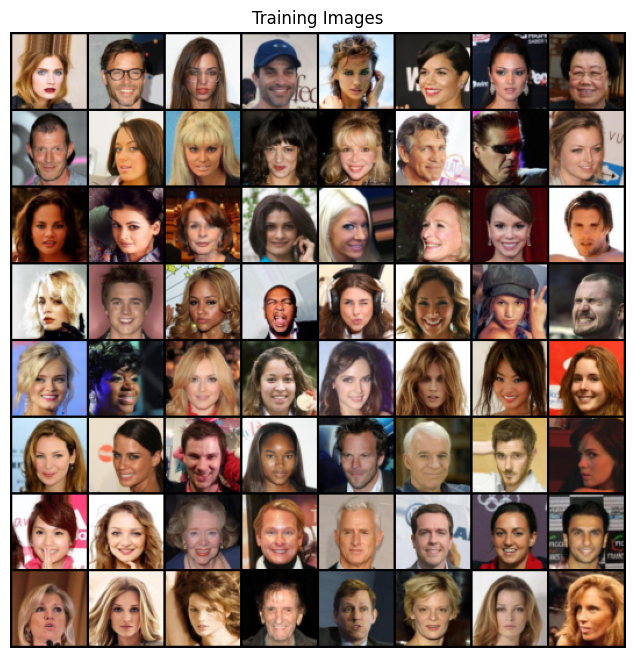

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Danh sách theo dõi tiến trình
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        #                                                             #
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        #                                                             #

        ## Train với all-real batch
        netD.zero_grad() #gradient bắt đầu với 0
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # đưa dữ liệu thật qua D
        output = netD(real_cpu).view(-1)
        # Tính toán loss on all-real batch
        errD_real = criterion(output, label)
        # Tính toán gradients cho D trong quá trình backward pass
        errD_real.backward()
        D_x = output.mean().item() #tính gtri trung bình của D

        ## Train với all-fake batch
        # Generate nhận vector tiềm ẩn ngẫu nhiên
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate tạo ảnh giả khi đưa vector tiềm ẩn qua G
        fake = netG(noise)
        label.fill_(fake_label)
        # Nhận ảnh giả vào D
        output = netD(fake.detach()).view(-1)
        # Tính toán D's loss trên toàn bộ fake batch
        errD_fake = criterion(output, label)
        # Tính toán gradients cho batch, tổng hợp với độ dốc trước đó
        errD_fake.backward()
        D_G_z1 = output.mean().item() # tính tb của D(G(z))
        # Tổng loss D
        errD = errD_real + errD_fake
        # Cập nhật tham số D
        optimizerD.step()

        #                                             #
        # (2) Update G network: maximize log(D(G(z))) #
        #                                             #

        netG.zero_grad() #gradient ban đầu với 0
        label.fill_(real_label)  # nhãn sinh ra đối với G được coi là nhãn thật
        # Đưa ảnh giả qua mạng D
        output = netD(fake).view(-1)
        # Tính loss của g dựa trên output của D và nhãn thật
        errG = criterion(output, label)
        # Tính toán gradients cho G
        errG.backward()
        D_G_z2 = output.mean().item() #tính gtri tb
        # Cập nhật tham số G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0: #đưa ra thông tin huấn luyện sau mỗi 50 batch
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Lưu lại giá trị loss
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Ghi lại và theo dõi thông tin quan trọng như hàm mất mát và độ tin cậy của Discriminator với dữ liệu thật và dữ liệu giả.
        # Kiểm tra hoạt động của G, lấy đầu ra với fixed_nosie và lưu vào img_list
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/323]	Loss_D: 1.5938	Loss_G: 5.6457	D(x): 0.5763	D(G(z)): 0.5501 / 0.0058
[0/5][50/323]	Loss_D: 0.4801	Loss_G: 23.0691	D(x): 0.8159	D(G(z)): 0.0000 / 0.0000
[0/5][100/323]	Loss_D: 0.5466	Loss_G: 11.3472	D(x): 0.9782	D(G(z)): 0.3512 / 0.0000
[0/5][150/323]	Loss_D: 0.5291	Loss_G: 6.0230	D(x): 0.7242	D(G(z)): 0.0379 / 0.0074
[0/5][200/323]	Loss_D: 0.4355	Loss_G: 5.5348	D(x): 0.8154	D(G(z)): 0.1040 / 0.0064
[0/5][250/323]	Loss_D: 0.5062	Loss_G: 7.1480	D(x): 0.7398	D(G(z)): 0.0058 / 0.0015
[0/5][300/323]	Loss_D: 0.7421	Loss_G: 2.8877	D(x): 0.7020	D(G(z)): 0.1681 / 0.1281
[1/5][0/323]	Loss_D: 0.6770	Loss_G: 4.8905	D(x): 0.8697	D(G(z)): 0.3587 / 0.0126
[1/5][50/323]	Loss_D: 0.6141	Loss_G: 5.4224	D(x): 0.8998	D(G(z)): 0.3327 / 0.0216
[1/5][100/323]	Loss_D: 0.6179	Loss_G: 5.7082	D(x): 0.8366	D(G(z)): 0.2829 / 0.0087
[1/5][150/323]	Loss_D: 1.1330	Loss_G: 5.0323	D(x): 0.8752	D(G(z)): 0.4524 / 0.0454
[1/5][200/323]	Loss_D: 0.6349	Loss_G: 5.5230	D(x): 0.7893	D(G(z))

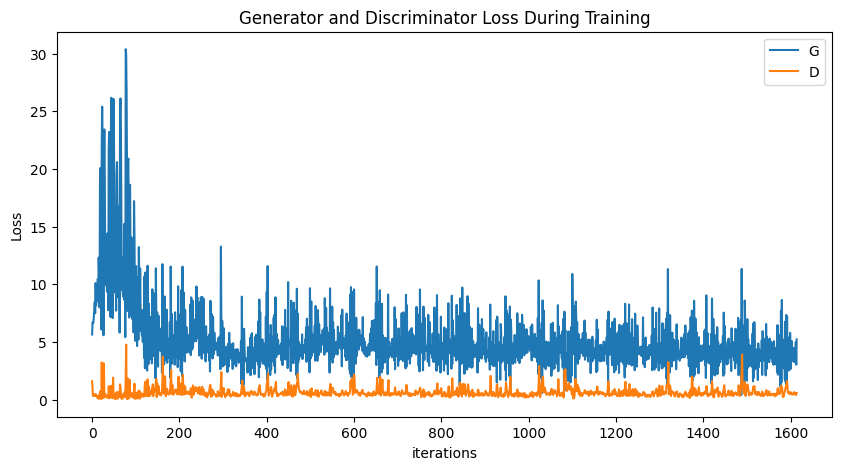

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

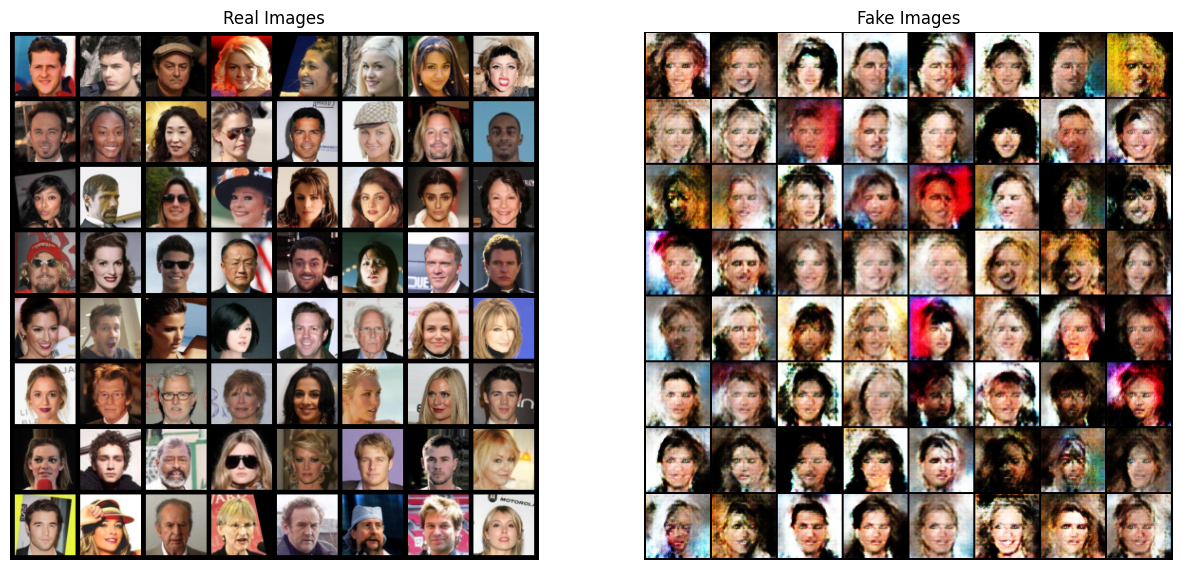

In [ ]:
# Lấy ra ảnh thật từ trình tải dữ liệu
real_batch = next(iter(dataloader))

# Show ảnh thật
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Show ảnh fake từ epoch cuối cùng
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()